In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive, output
import sys
import time
output.clear()
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from scipy.stats import zscore
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif, chi2
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score, confusion_matrix, roc_auc_score
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import CategoricalNB
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.model_selection import cross_validate, GridSearchCV
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.utils import shuffle

drive.mount('/content/gdrive')
drive_data_path = 'gdrive/My Drive/'
output.clear()

In [ ]:
# https://www.kaggle.com/c/sf-crime
df = pd.read_csv(drive_data_path+"Crimes.csv", sep=',', index_col=None)
df['Dates'] = pd.to_datetime(df['Dates'], format='%Y-%m-%d %H:%M:%S')
df.head()

,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y
0,2015-05-13 23:53:00,WARRANTS,WARRANT ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599
1,2015-05-13 23:53:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599
2,2015-05-13 23:33:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",VANNESS AV / GREENWICH ST,-122.424363,37.800414
3,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,NORTHERN,NONE,1500 Block of LOMBARD ST,-122.426995,37.800873
4,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,PARK,NONE,100 Block of BRODERICK ST,-122.438738,37.771541


In [ ]:
df['Year'] = df['Dates'].dt.year
df['Month'] = df['Dates'].dt.month
df['Day'] = df['Dates'].dt.day
df['DayOfYear'] = df['Dates'].dt.dayofyear
df['Date'] = df['Dates'].dt.date
df['Hour'] = df['Dates'].dt.hour
df['Minute'] = df['Dates'].dt.minute
df['Time'] = df['Dates'].dt.time

# df.drop(columns=['Resolution', 'Descript'], inplace=True)

In [ ]:
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 878049 entries, 0 to 878048
Data columns (total 15 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   Dates       878049 non-null  datetime64[ns]
 1   Category    878049 non-null  object        
 2   DayOfWeek   878049 non-null  object        
 3   PdDistrict  878049 non-null  object        
 4   Address     878049 non-null  object        
 5   X           878049 non-null  float64       
 6   Y           878049 non-null  float64       
 7   Year        878049 non-null  int64         
 8   Month       878049 non-null  int64         
 9   Day         878049 non-null  int64         
 10  DayOfYear   878049 non-null  int64         
 11  Date        878049 non-null  object        
 12  Hour        878049 non-null  int64         
 13  Minute      878049 non-null  int64         
 14  Time        878049 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(6), object(

,X,Y,Year,Month,Day,DayOfYear,Hour,Minute
count,878049.000000,878049.000000,878049.000000,878049.000000,878049.000000,878049.000000,878049.000000,878049.000000
mean,-122.422616,37.771020,2008.712046,6.436509,15.570623,180.332158,13.412655,20.155026
std,0.030354,0.456893,3.631194,3.428972,8.783005,104.897857,6.549573,18.594915
min,-122.513642,37.707879,2003.000000,1.000000,1.000000,1.000000,0.000000,0.000000
25%,-122.432952,37.752427,2006.000000,3.000000,8.000000,90.000000,9.000000,0.000000
50%,-122.416420,37.775421,2009.000000,6.000000,16.000000,179.000000,14.000000,19.000000
75%,-122.406959,37.784369,2012.000000,9.000000,23.000000,273.000000,19.000000,33.000000
max,-120.500000,90.000000,2015.000000,12.000000,31.000000,365.000000,23.000000,59.000000


In [ ]:
df.describe(include="O")

,Category,DayOfWeek,PdDistrict,Address,Date,Time
count,878049,878049,878049,878049,878049,878049
unique,39,7,10,23228,2249,1439
top,LARCENY/THEFT,Friday,SOUTHERN,800 Block of BRYANT ST,2011-01-01,12:00:00
freq,174900,133734,157182,26533,650,22351


In [ ]:
print(df.duplicated().value_counts())
df = df.drop_duplicates()

False    875726
True       2323
dtype: int64


In [ ]:
print(df.drop(columns=['Resolution', 'Descript']).duplicated().value_counts())
print()
print(df.drop(columns=['Resolution', 'Descript', 'Category']).duplicated().value_counts())

False    812590
True      63136
dtype: int64

False    689094
True     186632
dtype: int64


LARCENY/THEFT                  172607
OTHER OFFENSES                 116715
NON-CRIMINAL                    90379
ASSAULT                         68493
VANDALISM                       43762
VEHICLE THEFT                   41482
DRUG/NARCOTIC                   39775
WARRANTS                        39234
BURGLARY                        36222
SUSPICIOUS OCC                  30940
ROBBERY                         22565
MISSING PERSON                  19405
FRAUD                           16096
FORGERY/COUNTERFEITING          10021
SECONDARY CODES                  9931
WEAPON LAWS                      7579
TRESPASS                         7268
PROSTITUTION                     5791
STOLEN PROPERTY                  4478
DRUNKENNESS                      4277
DISORDERLY CONDUCT               4270
SEX OFFENSES FORCIBLE            3868
RECOVERED VEHICLE                3128
KIDNAPPING                       2241
DRIVING UNDER THE INFLUENCE      2229
RUNAWAY                          1873
LIQUOR LAWS 

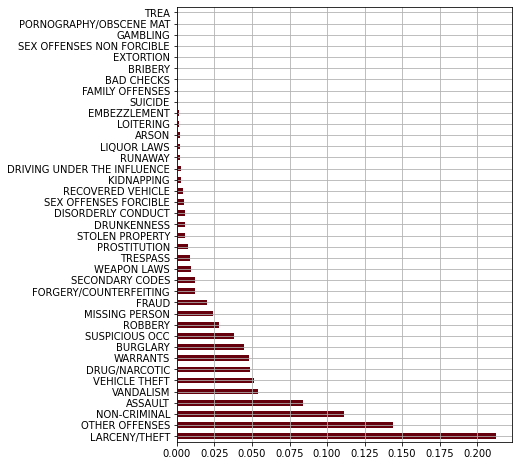

In [ ]:
#проверка сбалансированности классов
print(df['Category'].value_counts(normalize=False))
df['Category'].value_counts(normalize=True).plot(kind='barh', grid=True, colormap='Reds_r', figsize=(6,8))

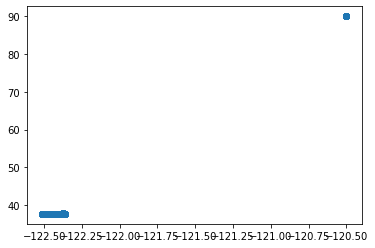

In [ ]:
plt.scatter(df.X, df.Y)

In [ ]:
print(df[df['Y']>50]['Category'].count(), 'outliers')
df[df['Y']>50]['Address'].value_counts()

67 outliers


LARKIN ST / AUSTIN ST                           6
AUSTIN ST / LARKIN ST                           6
BRANNAN ST / 1ST ST                             3
5THSTNORTH ST / EDDY ST                         3
7THSTNORTH ST / MCALLISTER ST                   3
JOHN F KENNEDY DR / MARTIN LUTHER KING JR DR    2
JAMES LICK FREEWAY HY / CESAR CHAVEZ ST         2
GILMAN AV / FITCH ST                            2
STCHARLES AV / 19TH AV                          2
JENNINGS CT / INGALLS ST                        2
AVENUE OF THE PALMS / EUCLID AV                 2
TURK ST / STJOSEPHS AV                          2
ELLIS ST / 5THSTNORTH ST                        2
EDDY ST / 5THSTNORTH ST                         2
JAMESLICKFREEWAY HY / SILVER AV                 2
VANNESS AV / BEACH ST                           1
ARGUELLO BL / NORTHRIDGE DR                     1
3RD ST / JAMES LICK FREEWAY HY                  1
1ST ST / BRANNAN ST                             1
I-280 / CESAR CHAVEZ ST                         1


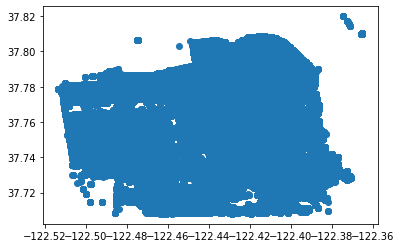

In [ ]:
# df.reset_index(drop=True, inplace=True)
# # df.replace({'X': -120.5, 'Y': 90.0}, np.NaN, inplace=True)
# index = df['Y'].index[df['Y'].apply(lambda x: x>40)]
# print(len(index))
# for i in index:
#   df.loc[i, 'X'] = df[df['Address']==df.iloc[i]['Address']]['X'].mean()
#   df.loc[i, 'Y'] = df[df['Address']==df.iloc[i]['Address']]['Y'].mean()
df = df[df['Y']<40]
plt.scatter(df.X, df.Y)

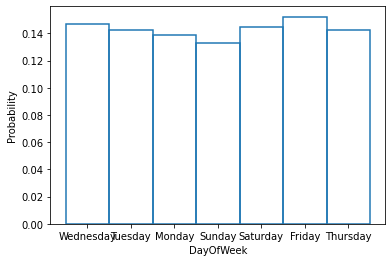

In [ ]:
sns.histplot(x = 'DayOfWeek', data = df, kde=False, element="bars",
    stat="probability",fill=False, legend=False)

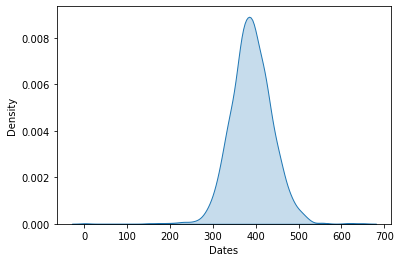

In [ ]:
sns.kdeplot(data=df.groupby('Date').count().iloc[:, 0], shade=True)

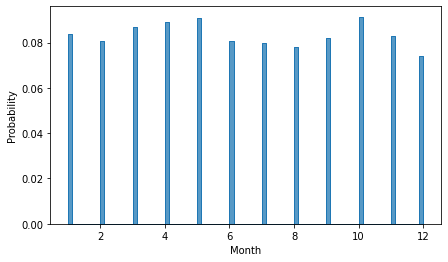

In [ ]:
plt.figure(figsize=(7,4))
sns.histplot(data=df, x='Month',  kde=False, element="step",
    stat="probability")

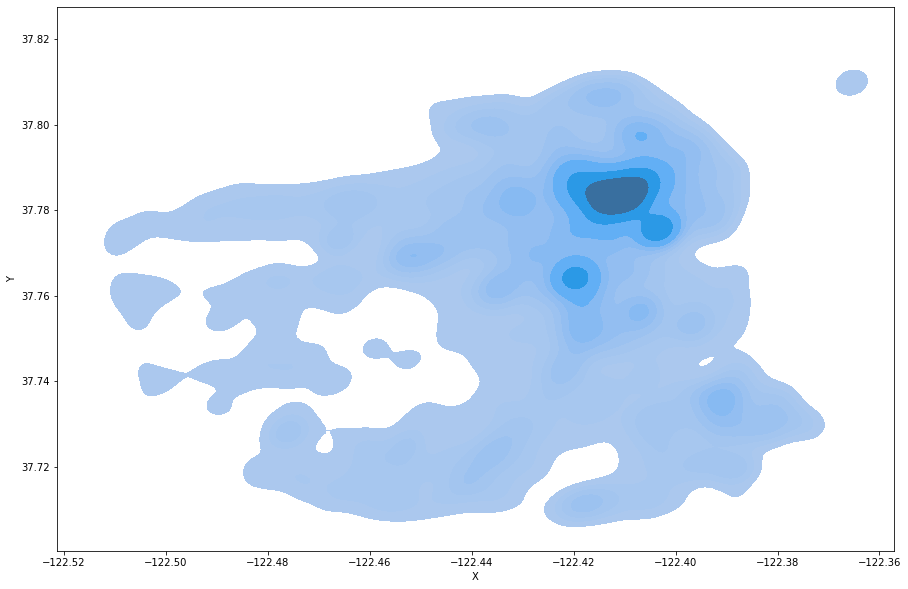

In [ ]:
plt.figure(figsize=(15,10))
sns.kdeplot(data=df, x='X', y='Y', fill=True)

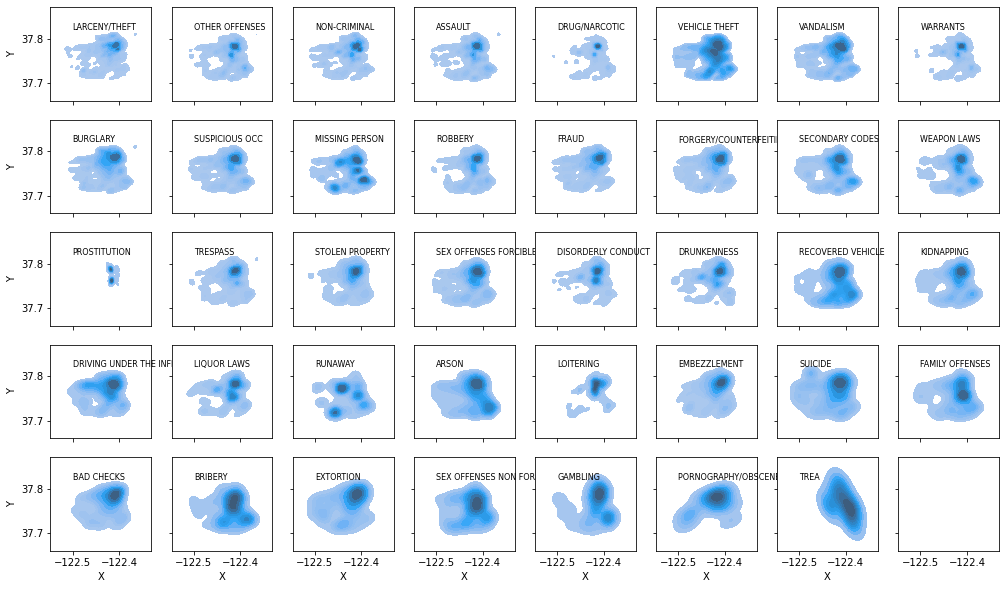

In [ ]:
fig, axes = plt.subplots(nrows=5, ncols=8, figsize=(17,10), sharex=True, sharey=True)
for idx, crime in  enumerate(df['Category'].value_counts().index.tolist()):
    sns.kdeplot(x='X', y='Y', data=df[df['Category']==crime], ax=axes[idx//8, idx%8], fill=True)
    axes[idx//8, idx%8].text(-122.5, 37.82, crime, fontsize=8)
    # sns.scatterplot(x='X', y='Y', data=df[df['Category']==crime], ax=axes[idx//8, idx%8], s=5)
plt.show()

In [ ]:
def split_address(adr):
  addr = str(adr)
  if ' / ' in addr:
    return '-', False, True, addr.split(' / ')[0], addr.split(' / ')[1]
  elif ' Block ' in addr:
    return str(addr.split(' Block ')[0]), True, False, addr.split(' of ')[1], '-'
  elif '/' in addr:
    return '-', False, True, addr.split('/')[0], '-'
  else:
    return '-', False, False, '-', '-'


df['N_Block'], df['Block'], df['Crossroad'], df['Street1'], df['Street2'] = zip(*df['Address'].apply(split_address))

df.head()

,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y,Year,Month,Day,DayOfYear,Date,Hour,Minute,Time,N_Block,Block,Crossroad,Street1,Street2
0,2015-05-13 23:53:00,WARRANTS,WARRANT ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599,2015,5,13,133,2015-05-13,23,53,23:53:00,-,False,True,OAK ST,LAGUNA ST
1,2015-05-13 23:53:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599,2015,5,13,133,2015-05-13,23,53,23:53:00,-,False,True,OAK ST,LAGUNA ST
2,2015-05-13 23:33:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",VANNESS AV / GREENWICH ST,-122.424363,37.800414,2015,5,13,133,2015-05-13,23,33,23:33:00,-,False,True,VANNESS AV,GREENWICH ST
3,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,NORTHERN,NONE,1500 Block of LOMBARD ST,-122.426995,37.800873,2015,5,13,133,2015-05-13,23,30,23:30:00,1500,True,False,LOMBARD ST,-
4,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,PARK,NONE,100 Block of BRODERICK ST,-122.438738,37.771541,2015,5,13,133,2015-05-13,23,30,23:30:00,100,True,False,BRODERICK ST,-


In [ ]:
df['TimeSin'] = np.sin(np.pi * (df.Hour + df.Minute/60) / 12) +1
df['TimeCos'] = np.cos(np.pi * (df.Hour + df.Minute/60) / 12) +1
df['DateSin'] = np.sin(2* np.pi * df.DayOfYear / 365) +1
df['DateCos'] = np.cos(2* np.pi * df.DayOfYear / 365) +1

df['X'] = df['X']+123

In [ ]:
print(df.columns)

Index(['Dates', 'Category', 'Descript', 'DayOfWeek', 'PdDistrict',
       'Resolution', 'Address', 'X', 'Y', 'Year', 'Month', 'Day', 'DayOfYear',
       'Date', 'Hour', 'Minute', 'Time', 'N_Block', 'Block', 'Crossroad',
       'Street1', 'Street2', 'TimeSin', 'TimeCos', 'DateSin', 'DateCos'],
      dtype='object')


In [ ]:
!pip install eli5
import eli5
from sklearn.preprocessing import LabelEncoder
from eli5.sklearn import PermutationImportance
from sklearn.model_selection import train_test_split
output.clear()

used_df = df.drop(columns=['Resolution', 'Descript',  'Address', 'Date', 'Time', 'Dates'])
le1 = LabelEncoder()
used_df['PdDistrict'] = le1.fit_transform(used_df['PdDistrict'])
used_df['DayOfWeek'] = le1.fit_transform(used_df['DayOfWeek'])
used_df['N_Block'] = le1.fit_transform(used_df['N_Block'])
le1.fit(df.Street1.append(df.Street2))
used_df['Street1'] = le1.transform(used_df['Street1'])
used_df['Street2'] = le1.transform(used_df['Street2'])
le2 = LabelEncoder()
y = le2.fit_transform(used_df.pop('Category'))

train_X, val_X, train_y, val_y = train_test_split(used_df, y)

In [ ]:
import lightgbm as lgb
from lightgbm import LGBMClassifier

start = time.time()
model =LGBMClassifier(objective='multiclass', num_class=39).fit(train_X, train_y)
end = time.time() 
print((end - start)//60, 'min, ', round((end - start)%60), 's')

start = time.time()
perm = PermutationImportance(model).fit(val_X, val_y)
end = time.time() 
print((end - start)//60, 'min, ', round((end - start)%60), 's')
eli5.show_weights(perm, feature_names=val_X.columns.tolist())

299.3825113773346


Weight,Feature
0.0574 ± 0.0009,Minute
0.0481 ± 0.0011,Y
0.0433 ± 0.0007,DayOfYear
0.0347 ± 0.0005,X
0.0243 ± 0.0006,DateCos
0.0219 ± 0.0008,DateSin
0.0218 ± 0.0003,TimeCos
0.0173 ± 0.0004,TimeSin
0.0128 ± 0.0007,Year
0.0124 ± 0.0004,PdDistrict


In [ ]:
eli5.show_weights(model, feature_names=val_X.columns.tolist())

Weight,Feature
0.4121,Street2
0.1836,Minute
0.0624,X
0.0619,TimeSin
0.0609,DateCos
0.0512,DayOfYear
0.0419,TimeCos
0.0418,Street1
0.0216,DateSin
0.0162,Y


In [ ]:
model.score(val_X, val_y)

0.28516090720142523

In [ ]:
from sklearn.metrics import log_loss
pred_log_y = model.predict_proba(val_X)
print(log_loss(val_y, pred_log_y))

In [ ]:
from sklearn.naive_bayes import BernoulliNB
bnb = BernoulliNB()
bnb.fit(train_X, train_y)
bnb.score(val_X, val_y)

0.22496402713381905

In [ ]:
start = time.time()
perm = PermutationImportance(bnb).fit(val_X, val_y)
end = time.time() 
print((end - start)//60, 'min, ', round((end - start)%60), 's')
eli5.show_weights(perm, feature_names=val_X.columns.tolist())

0.0 min,  16 s


Weight,Feature
0.0216 ± 0.0011,Minute
0.0095 ± 0.0006,PdDistrict
0.0011 ± 0.0003,Hour
0.0008 ± 0.0003,TimeCos
0.0005 ± 0.0002,TimeSin
0 ± 0.0000,DayOfYear
0 ± 0.0000,X
0 ± 0.0000,Y
0 ± 0.0000,Year
0 ± 0.0000,Month
